# Project 2

## Dependencies
- Pip Packages
    - fredapi
    - pandas
- General
    - FRED API Key
    
## Table of Contents

- [Get FRED Data](#Get-FRED-Data)
- [US Data](#US-Data)
- [Data Cleaning](#Data-Cleaning)
- [Plots](#Plots)
- [Feature Selection](#Feature-Selection)
- [Models](#Models)
- [Reporting](#Reporting)
- [Canada Data](#Canada-Data)

_PS: You can use the above anchors when you're in the Jupyter Notebook or in the HTML. Try clicking on one!_

In [1]:
#pip install pandas_datareader
#You may need to uncomment above line and run so you have needed libraries

In [2]:
from fredapi import Fred
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from functools import reduce
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Get FRED Data

In [3]:
# Key: 02d60bd3174b5444867a02671ae80475
api_key = input("Please input your FRED API Key:\n").strip()
fred = Fred(api_key=api_key)

Please input your FRED API Key:
02d60bd3174b5444867a02671ae80475


## US Data
- US Recession Index (FRED)
- US GDP (FRED)
- US GDP Percent Change (Calculated)
- U.S. Unemployment Rate (FRED)
- U.S. Unemployment Rate % Change (Calculated)
- SP500 (Yahoo Finance)
- NASDAQ100 (FRED)
- Treasury Yield Curve (FRED)

In [4]:
def get_fred_series(name: str, date: str, label: str, to_frame: bool = True, pct_change: bool = False, periods: int = None, freq=None):
    """ Gets the FRED Series in Name, from Date, and inputs the data into a label 
        Assumes that data is in format of: "date", "value"
    """
    series = fred.get_series(name)
    if to_frame:
        series = series.to_frame()
    if pct_change:
        if not freq and not periods:
            series = series.pct_change()
        elif freq:
            series = series.pct_change(freq=freq)
        elif periods:
            series = series.pct_change(periods=periods)
    series = series.loc[date:]
    series[label] = series[0]
    return series.drop(columns = 0)

In [5]:
us_rec = get_fred_series('JHDUSRGDPBR', '1970-01-01', 'is_recession')
us_rec

,is_recession
1970-01-01,1.0
1970-04-01,1.0
1970-07-01,1.0
1970-10-01,1.0
1971-01-01,0.0
...,...
2019-04-01,0.0
2019-07-01,0.0
2019-10-01,1.0
2020-01-01,1.0


In [6]:
us_gdp = get_fred_series('GDP', '1970-01-01', 'US_GDP')
us_gdp['US_GDP']*1000000000

1970-01-01    1.051200e+12
1970-04-01    1.067375e+12
1970-07-01    1.086059e+12
1970-10-01    1.088608e+12
1971-01-01    1.135156e+12
                  ...     
2019-07-01    2.154032e+13
2019-10-01    2.174739e+13
2020-01-01    2.156114e+13
2020-04-01    1.952011e+13
2020-07-01    2.115712e+13
Name: US_GDP, Length: 203, dtype: float64

In [7]:
us_gdp_pctcg = get_fred_series('GDP', '1970-01-01', 'US_GDP_%Change', pct_change=True)
us_gdp_pctcg

,US_GDP_%Change
1970-01-01,0.012573
1970-04-01,0.015387
1970-07-01,0.017505
1970-10-01,0.002347
1971-01-01,0.042759
...,...
2019-07-01,0.009866
2019-10-01,0.009613
2020-01-01,-0.008564
2020-04-01,-0.094662


In [8]:
unemp = fred.get_series('UNRATE').loc['1970-01-01':].to_frame()
unemp['US Unemp'] = unemp[0]
unemp = unemp.drop(columns = 0)
unemp

,US Unemp
1970-01-01,3.9
1970-02-01,4.2
1970-03-01,4.4
1970-04-01,4.6
1970-05-01,4.8
...,...
2020-07-01,10.2
2020-08-01,8.4
2020-09-01,7.9
2020-10-01,6.9


In [9]:
unemp = get_fred_series('UNRATE', '1970-01-01', 'US Unemp')
unemp

,US Unemp
1970-01-01,3.9
1970-02-01,4.2
1970-03-01,4.4
1970-04-01,4.6
1970-05-01,4.8
...,...
2020-07-01,10.2
2020-08-01,8.4
2020-09-01,7.9
2020-10-01,6.9


In [10]:
unemp_pct = get_fred_series('UNRATE', '1970-01-01', 'US Unemp % Change', pct_change=True)
unemp_pct

,US Unemp % Change
1970-01-01,0.114286
1970-02-01,0.076923
1970-03-01,0.047619
1970-04-01,0.045455
1970-05-01,0.043478
...,...
2020-07-01,-0.081081
2020-08-01,-0.176471
2020-09-01,-0.059524
2020-10-01,-0.126582


In [11]:
sp500 = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today())
sp500.rename(columns = {'Adj Close' : "SPX500 % Change"}, inplace=True)
sp500 = sp500["SPX500 % Change"].pct_change().to_frame()
sp500

,SPX500 % Change
Date,
1970-01-02,NaN
1970-01-05,0.004946
1970-01-06,-0.006848
1970-01-07,-0.002047
1970-01-08,0.000540
...,...
2020-11-30,-0.004596
2020-12-01,0.011271
2020-12-02,0.001791


In [12]:
sp_raw = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today())['Adj Close'].to_frame().rename(columns = {'Adj Close':'SPX Raw'})
sp_raw = sp_raw.resample('M').mean()
sp_raw.index = sp_raw.index + pd.Timedelta('1 day')
sp_raw

,SPX Raw
Date,
1970-02-01,90.332857
1970-03-01,87.164211
1970-04-01,88.652381
1970-05-01,85.952272
1970-06-01,76.061429
...,...
2020-09-01,3391.710019
2020-10-01,3365.516671
2020-11-01,3418.699996


In [13]:
nascom = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM')
nascom

,NASDAQCOM
1971-02-05,100.00
1971-02-08,100.84
1971-02-09,100.76
1971-02-10,100.69
1971-02-11,101.45
...,...
2020-11-27,12205.85
2020-11-30,12198.74
2020-12-01,12355.11
2020-12-02,12349.37


In [14]:
nascom = nascom.resample('M').mean()
nascom.index = nascom.index + pd.Timedelta('1 day')
nascom

,NASDAQCOM
1971-03-01,100.963333
1971-04-01,104.470435
1971-05-01,109.555238
1971-06-01,109.570500
1971-07-01,108.567727
...,...
2020-09-01,11212.290381
2020-10-01,11088.679524
2020-11-01,11435.233864
2020-12-01,11794.461307


In [15]:
nascom_pct = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM % Chg', pct_change=True, freq='M')
nascom_pct

,NASDAQCOM % Chg
1971-02-05,NaN
1971-02-08,NaN
1971-02-09,NaN
1971-02-10,NaN
1971-02-11,NaN
...,...
2020-11-27,NaN
2020-11-30,0.113266
2020-12-01,NaN
2020-12-02,NaN


In [16]:
nascom_pct = nascom_pct.loc[nascom_pct['NASDAQCOM % Chg'].notnull() == True]
nascom_pct.index = nascom_pct.index + pd.Timedelta('1 day')
nascom_pct

,NASDAQCOM % Chg
1971-04-01,0.041167
1971-05-01,0.059734
1971-06-01,-0.036064
1971-07-01,-0.004157
1971-09-01,0.026802
...,...
2020-07-01,0.053048
2020-08-01,0.068250
2020-09-01,0.095873
2020-10-01,-0.051628


In [17]:
ycurve = get_fred_series('T10Y2Y', '1970-01-01', '10Y-2Y').resample('M').mean()
ycurve.index = ycurve.index + pd.Timedelta('1 day')
ycurve

,10Y-2Y
1976-07-01,0.801364
1976-08-01,0.981905
1976-09-01,1.137273
1976-10-01,1.178095
1976-11-01,1.427000
...,...
2020-09-01,0.510476
2020-10-01,0.544762
2020-11-01,0.637619
2020-12-01,0.704211


In [18]:
us_inflation = get_fred_series('FPCPITOTLZGUSA', '1970-01-01', 'US Inflation')
us_inflation

,US Inflation
1970-01-01,5.838255
1971-01-01,4.292767
1972-01-01,3.272278
1973-01-01,6.177760
1974-01-01,11.054805
1975-01-01,9.143147
1976-01-01,5.744813
1977-01-01,6.501684
1978-01-01,7.630964
1979-01-01,11.254471


In [19]:
us_inflation_pctch = get_fred_series('FPCPITOTLZGUSA', '1970-01-01', 'US Inflation % Change', pct_change=True)
us_inflation_pctch

,US Inflation % Change
1970-01-01,0.068810
1971-01-01,-0.264718
1972-01-01,-0.237723
1973-01-01,0.887908
1974-01-01,0.789452
1975-01-01,-0.172926
1976-01-01,-0.371681
1977-01-01,0.131749
1978-01-01,0.173690
1979-01-01,0.474843


In [20]:
us_employees = get_fred_series('MANEMP', '1970-01-01', 'US ManufactureEmps')
us_employees

,US ManufactureEmps
1970-01-01,18424.0
1970-02-01,18361.0
1970-03-01,18360.0
1970-04-01,18207.0
1970-05-01,18029.0
...,...
2020-07-01,12103.0
2020-08-01,12133.0
2020-09-01,12193.0
2020-10-01,12226.0


In [21]:
us_employees_chg = get_fred_series('MANEMP', '1970-01-01', 'US ManuEmps % Change', pct_change = True)
#us_employees_chg = us_employees_chg.pct_change().loc['1970-01-01':]
us_employees_chg

,US ManuEmps % Change
1970-01-01,-0.003300
1970-02-01,-0.003419
1970-03-01,-0.000054
1970-04-01,-0.008333
1970-05-01,-0.009776
...,...
2020-07-01,0.003399
2020-08-01,0.002479
2020-09-01,0.004945
2020-10-01,0.002706


In [22]:
us_loans_pctchg = get_fred_series('TOTCI', '1970-01-01', 'US Loans % Change', pct_change = True).resample('M').mean()
us_loans_pctchg

,US Loans % Change
1973-01-31,0.005568
1973-02-28,0.009797
1973-03-31,0.005914
1973-04-30,0.004029
1973-05-31,0.003589
...,...
2020-07-31,-0.003415
2020-08-31,-0.003515
2020-09-30,-0.006584
2020-10-31,-0.003423


In [23]:
us_loans_pctchg = us_loans_pctchg.loc[us_loans_pctchg['US Loans % Change'].notnull() == True]
us_loans_pctchg.index = us_loans_pctchg.index + pd.Timedelta('1 day')
us_loans_pctchg

,US Loans % Change
1973-02-01,0.005568
1973-03-01,0.009797
1973-04-01,0.005914
1973-05-01,0.004029
1973-06-01,0.003589
...,...
2020-08-01,-0.003415
2020-09-01,-0.003515
2020-10-01,-0.006584
2020-11-01,-0.003423


In [24]:
med_income = get_fred_series('MEHOINUSA672N', '1970-01-01', 'US Median Income').dropna()
med_income

,US Median Income
1984-01-01,52679.0
1985-01-01,53664.0
1986-01-01,55597.0
1987-01-01,56261.0
1988-01-01,56725.0
1989-01-01,57705.0
1990-01-01,56966.0
1991-01-01,55302.0
1992-01-01,54874.0
1993-01-01,54581.0


In [25]:
med_income_pct = get_fred_series('MEHOINUSA672N', '1970-01-01', 'US Median Income % Chg', pct_change = True).dropna()
med_income_pct

,US Median Income % Chg
1985-01-01,0.018698
1986-01-01,0.036020
1987-01-01,0.011943
1988-01-01,0.008247
1989-01-01,0.017276
1990-01-01,-0.012807
1991-01-01,-0.029210
1992-01-01,-0.007739
1993-01-01,-0.005340
1994-01-01,0.011616


In [26]:
'''outer = [us_rec, us_gdp, us_gdp_pctcg, unemp, unemp_pct, us_inflation, sp500,  med_income]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='outer'), outer)
inner = [df_merged, nascom_pct, ycurve, us_employees, us_employees_chg]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='inner'), inner)
df_merged = df_merged.iloc[:-2].fillna(method = 'ffill')
df_merged['US Inflation'].fillna((df_merged['US Inflation'].mean()), inplace=True)
df_merged['US Median Income'].fillna((df_merged['US Median Income'].mean()), inplace=True)'''



"outer = [us_rec, us_gdp, us_gdp_pctcg, unemp, unemp_pct, us_inflation, sp500,  med_income]\ndf_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,\n                                                how='outer'), outer)\ninner = [df_merged, nascom_pct, ycurve, us_employees, us_employees_chg]\ndf_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,\n                                                how='inner'), inner)\ndf_merged = df_merged.iloc[:-2].fillna(method = 'ffill')\ndf_merged['US Inflation'].fillna((df_merged['US Inflation'].mean()), inplace=True)\ndf_merged['US Median Income'].fillna((df_merged['US Median Income'].mean()), inplace=True)"

## Data Cleaning

In [27]:
# Macro: GDP,Unemployment, Inflation, Debt, ycurve, Manufacturing Employees
# Micro: SPX500, NASDAQCOM, Income

# Add a % Change for US Inflation
# Mathew will take care of the prerecorded NaN's

outer = [us_rec, us_gdp, us_gdp_pctcg, unemp, unemp_pct, us_inflation, us_inflation_pctch, sp500, sp_raw,  med_income, med_income_pct, nascom_pct, ycurve, us_employees_chg, nascom]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='outer'), outer)
inner = [df_merged, us_employees]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='inner'), inner)

# This line fills all nan values to most recent reported nan value reported in a column
df_merged = df_merged.iloc[:-2].fillna(method = 'ffill')
'''
# Because these 4 are reported at a later date, it fills the nan values previously to the average of all vals
df_merged.loc[df_merged['is_recession']==1, 'US Median Income'] = df_merged.loc[df_merged['is_recession']==1, 'US Median Income'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'US Median Income'])
df_merged.loc[df_merged['is_recession']==1, 'US Median Income % Chg'] = df_merged.loc[df_merged['is_recession']==1, 'US Median Income % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'US Median Income % Chg'])
df_merged.loc[df_merged['is_recession']==1, 'SPX500 % Change'] = df_merged.loc[df_merged['is_recession']==1, 'SPX500 % Change'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'SPX500 % Change'])
df_merged.loc[df_merged['is_recession']==1, 'NASDAQCOM % Chg'] = df_merged.loc[df_merged['is_recession']==1, 'NASDAQCOM % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, 'NASDAQCOM % Chg'])
df_merged.loc[df_merged['is_recession']==1, '10Y-2Y'] = df_merged.loc[df_merged['is_recession']==1, '10Y-2Y'].fillna( df_merged.groupby(['is_recession']).mean().loc[1.0, '10Y-2Y'])

df_merged.loc[df_merged['is_recession']==0, 'US Median Income'] = df_merged.loc[df_merged['is_recession']==0, 'US Median Income'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'US Median Income'])
df_merged.loc[df_merged['is_recession']==0, 'US Median Income % Chg'] = df_merged.loc[df_merged['is_recession']==0, 'US Median Income % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'US Median Income % Chg'])
df_merged.loc[df_merged['is_recession']==0, 'SPX500 % Change'] = df_merged.loc[df_merged['is_recession']==0, 'SPX500 % Change'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'SPX500 % Change'])
df_merged.loc[df_merged['is_recession']==0, 'NASDAQCOM % Chg'] = df_merged.loc[df_merged['is_recession']==0, 'NASDAQCOM % Chg'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, 'NASDAQCOM % Chg'])
df_merged.loc[df_merged['is_recession']==0, '10Y-2Y'] = df_merged.loc[df_merged['is_recession']==0, '10Y-2Y'].fillna( df_merged.groupby(['is_recession']).mean().loc[0.0, '10Y-2Y'])
df_merged
'''
df_merged

,is_recession,US_GDP,US_GDP_%Change,US Unemp,US Unemp % Change,US Inflation,US Inflation % Change,SPX500 % Change,SPX Raw,US Median Income,US Median Income % Chg,NASDAQCOM % Chg,10Y-2Y,US ManuEmps % Change,NASDAQCOM,US ManufactureEmps
1970-01-01,1.0,1051.200,0.012573,3.9,0.114286,5.838255,0.068810,NaN,NaN,NaN,NaN,NaN,NaN,-0.003300,NaN,18424.0
1970-02-01,1.0,1051.200,0.012573,4.2,0.076923,5.838255,0.068810,NaN,90.332857,NaN,NaN,NaN,NaN,-0.003419,NaN,18361.0
1970-03-01,1.0,1051.200,0.012573,4.4,0.047619,5.838255,0.068810,NaN,87.164211,NaN,NaN,NaN,NaN,-0.000054,NaN,18360.0
1970-04-01,1.0,1067.375,0.015387,4.6,0.045455,5.838255,0.068810,0.004909,88.652381,NaN,NaN,NaN,NaN,-0.008333,NaN,18207.0
1970-05-01,1.0,1067.375,0.015387,4.8,0.043478,5.838255,0.068810,-0.000981,85.952272,NaN,NaN,NaN,NaN,-0.009776,NaN,18029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,0.0,19520.114,-0.094662,13.3,-0.095238,1.812210,-0.258076,-0.028059,2761.975226,68703.0,0.068077,0.154472,0.432857,0.020890,8292.407762,11729.0
2020-06-01,0.0,19520.114,-0.094662,11.1,-0.165414,1.812210,-0.258076,0.003751,2919.608484,68703.0,0.068077,0.154472,0.503500,0.028391,9105.655650,12062.0
2020-07-01,0.0,21157.122,0.083863,10.2,-0.081081,1.812210,-0.258076,0.005022,3104.660933,68703.0,0.068077,0.053048,0.543636,0.003399,9839.970955,12103.0
2020-08-01,0.0,21157.122,0.083863,8.4,-0.176471,1.812210,-0.258076,0.005022,3207.619096,68703.0,0.068077,0.068250,0.475455,0.002479,10499.862909,12133.0


In [28]:
### Made the averaging a function so that we can use this later, if needed

def average_nan(merged: pd.DataFrame, columns: list) -> pd.DataFrame:
    """ Averages the null values based on recession """
    target = 'is_recession'
    for col in columns:
        merged.loc[merged[target] == 1, col] = merged.loc[
            merged[target] == 1, col].fillna( 
                merged.groupby([target]).mean().loc[1.0, col]
        )
        
        merged.loc[merged[target] == 0, col] = merged.loc[
            merged[target]==0, col].fillna( 
                merged.groupby([target]).mean().loc[0.0, col]
        )
    return merged

nan_cols = ['US Median Income', 'US Median Income % Chg', 'SPX500 % Change', 'NASDAQCOM % Chg', '10Y-2Y', 'NASDAQCOM', 'SPX Raw']
df_merged = average_nan(df_merged, nan_cols)

In [29]:
df_merged

,is_recession,US_GDP,US_GDP_%Change,US Unemp,US Unemp % Change,US Inflation,US Inflation % Change,SPX500 % Change,SPX Raw,US Median Income,US Median Income % Chg,NASDAQCOM % Chg,10Y-2Y,US ManuEmps % Change,NASDAQCOM,US ManufactureEmps
1970-01-01,1.0,1051.200,0.012573,3.9,0.114286,5.838255,0.068810,-0.000626,591.412857,60120.5,-0.007593,-0.002872,0.344628,-0.003300,1281.277182,18424.0
1970-02-01,1.0,1051.200,0.012573,4.2,0.076923,5.838255,0.068810,-0.000626,90.332857,60120.5,-0.007593,-0.002872,0.344628,-0.003419,1281.277182,18361.0
1970-03-01,1.0,1051.200,0.012573,4.4,0.047619,5.838255,0.068810,-0.000626,87.164211,60120.5,-0.007593,-0.002872,0.344628,-0.000054,1281.277182,18360.0
1970-04-01,1.0,1067.375,0.015387,4.6,0.045455,5.838255,0.068810,0.004909,88.652381,60120.5,-0.007593,-0.002872,0.344628,-0.008333,1281.277182,18207.0
1970-05-01,1.0,1067.375,0.015387,4.8,0.043478,5.838255,0.068810,-0.000981,85.952272,60120.5,-0.007593,-0.002872,0.344628,-0.009776,1281.277182,18029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,0.0,19520.114,-0.094662,13.3,-0.095238,1.812210,-0.258076,-0.028059,2761.975226,68703.0,0.068077,0.154472,0.432857,0.020890,8292.407762,11729.0
2020-06-01,0.0,19520.114,-0.094662,11.1,-0.165414,1.812210,-0.258076,0.003751,2919.608484,68703.0,0.068077,0.154472,0.503500,0.028391,9105.655650,12062.0
2020-07-01,0.0,21157.122,0.083863,10.2,-0.081081,1.812210,-0.258076,0.005022,3104.660933,68703.0,0.068077,0.053048,0.543636,0.003399,9839.970955,12103.0
2020-08-01,0.0,21157.122,0.083863,8.4,-0.176471,1.812210,-0.258076,0.005022,3207.619096,68703.0,0.068077,0.068250,0.475455,0.002479,10499.862909,12133.0


## Plots

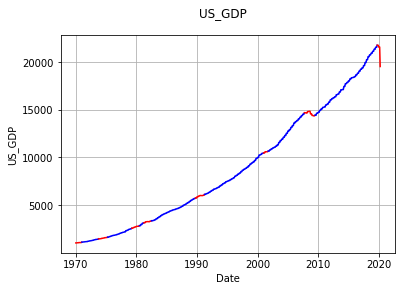

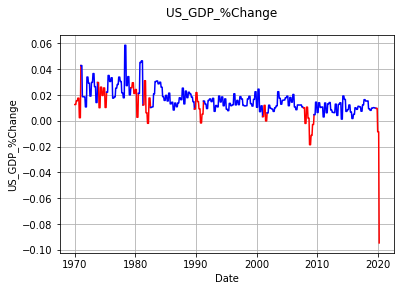

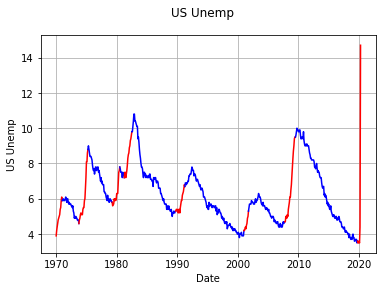

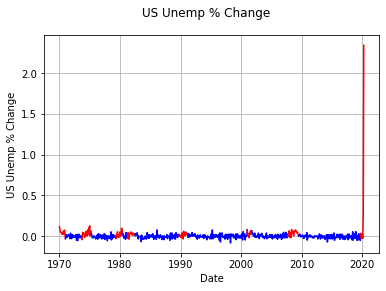

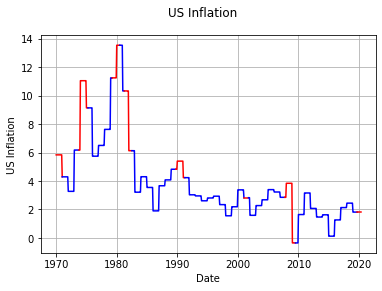

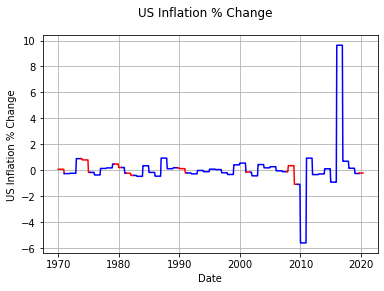

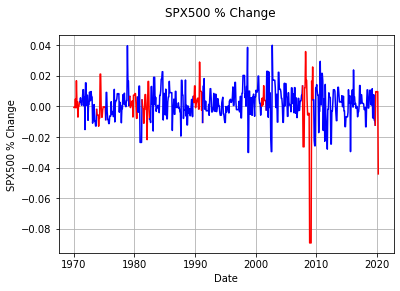

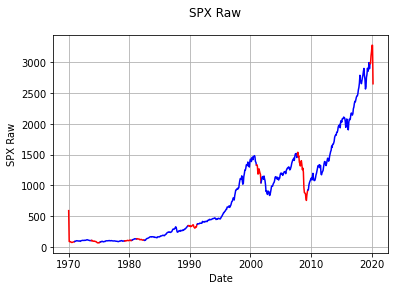

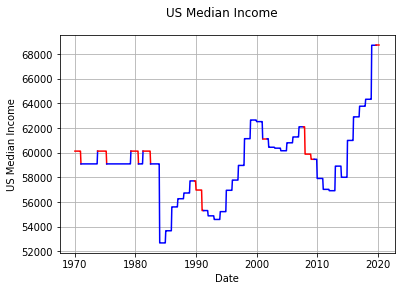

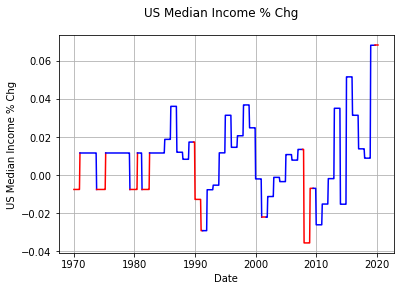

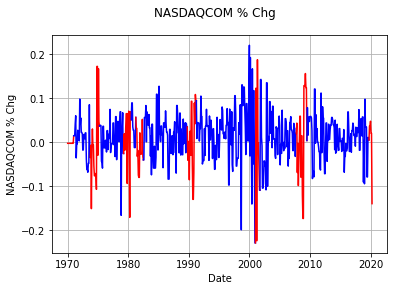

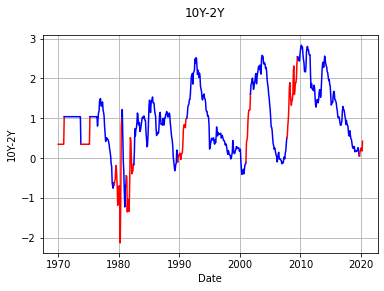

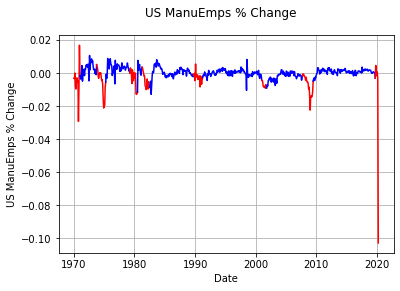

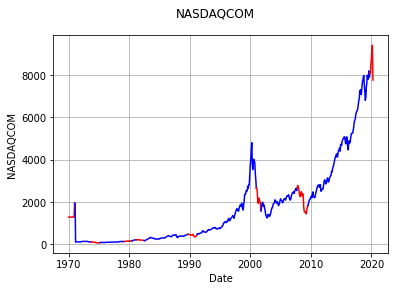

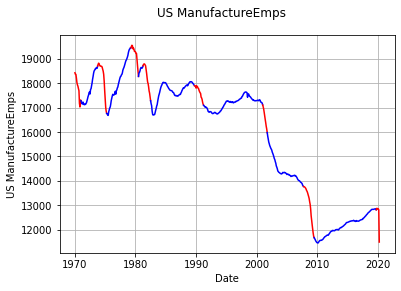

In [30]:
import numpy
from matplotlib import pyplot as plt

for column in df_merged.columns[1:]:
    fig = plt.figure()
    fig.suptitle(column)
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.grid()
    x=[]
    y=[]
    r=0
    for date, row in df_merged.iterrows():
        x.append(date.to_pydatetime())
        y.append(row[column])
        if r != row['is_recession']:
            if row['is_recession'] == 0:
                r=0
                plt.plot(x, y, 'r')
            else:
                r=1
                plt.plot(x, y, 'b')
            x=[date.to_pydatetime()]
            y=[row[column]]
    plt.show()
        

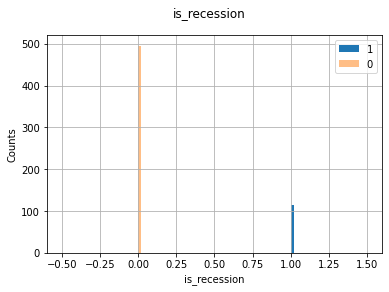

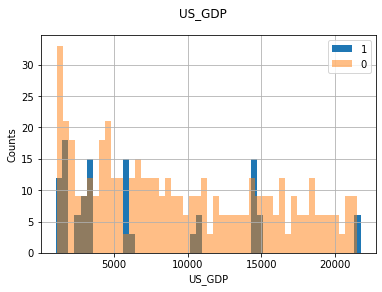

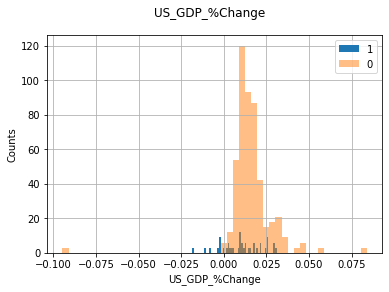

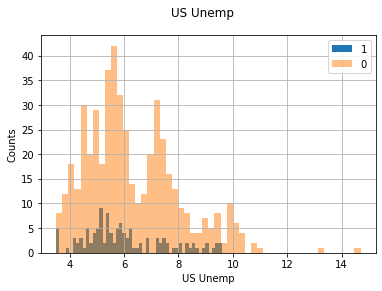

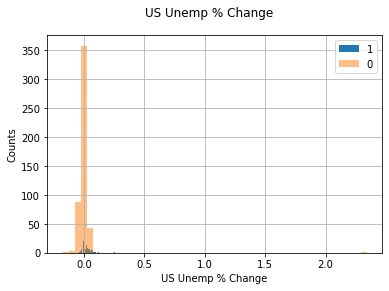

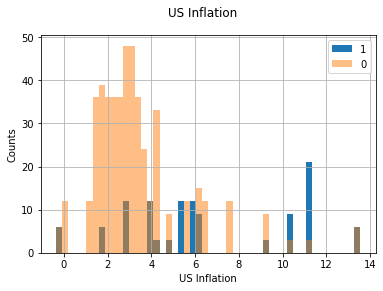

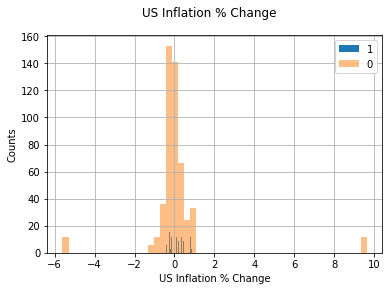

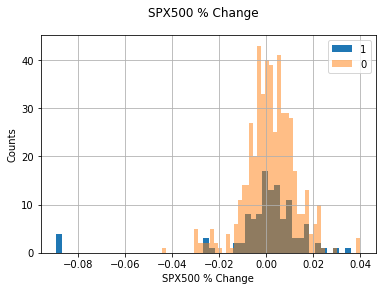

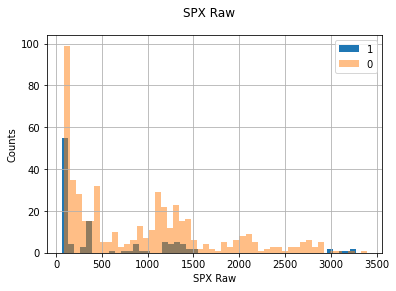

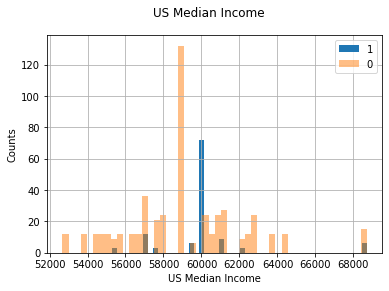

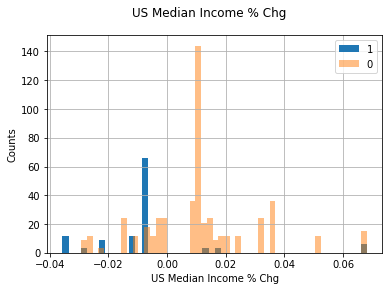

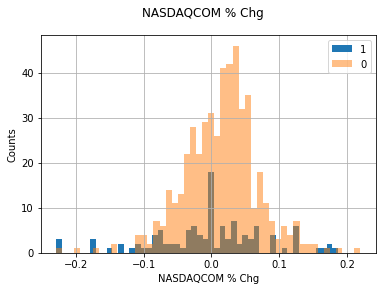

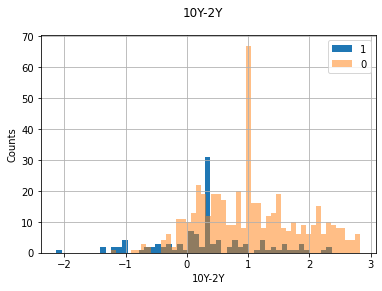

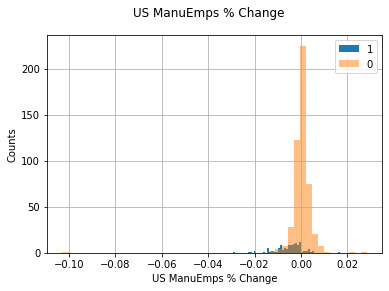

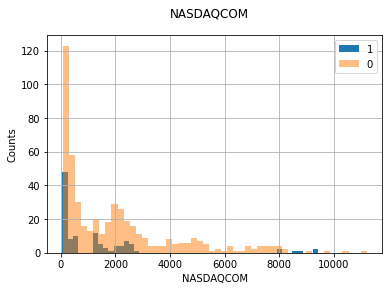

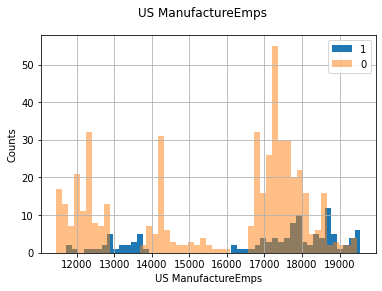

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

for column in df_merged.columns:
    fig = plt.figure()
    fig.suptitle(column)
    plt.xlabel(column)
    plt.ylabel("Counts")
    df_merged.query('is_recession==1')[column].hist(bins=50, legend=True)
    df_merged.query('is_recession==0')[column].hist(bins=50, alpha=0.5, legend=True)
    plt.legend(['1', '0'])
    plt.show()

<AxesSubplot:>

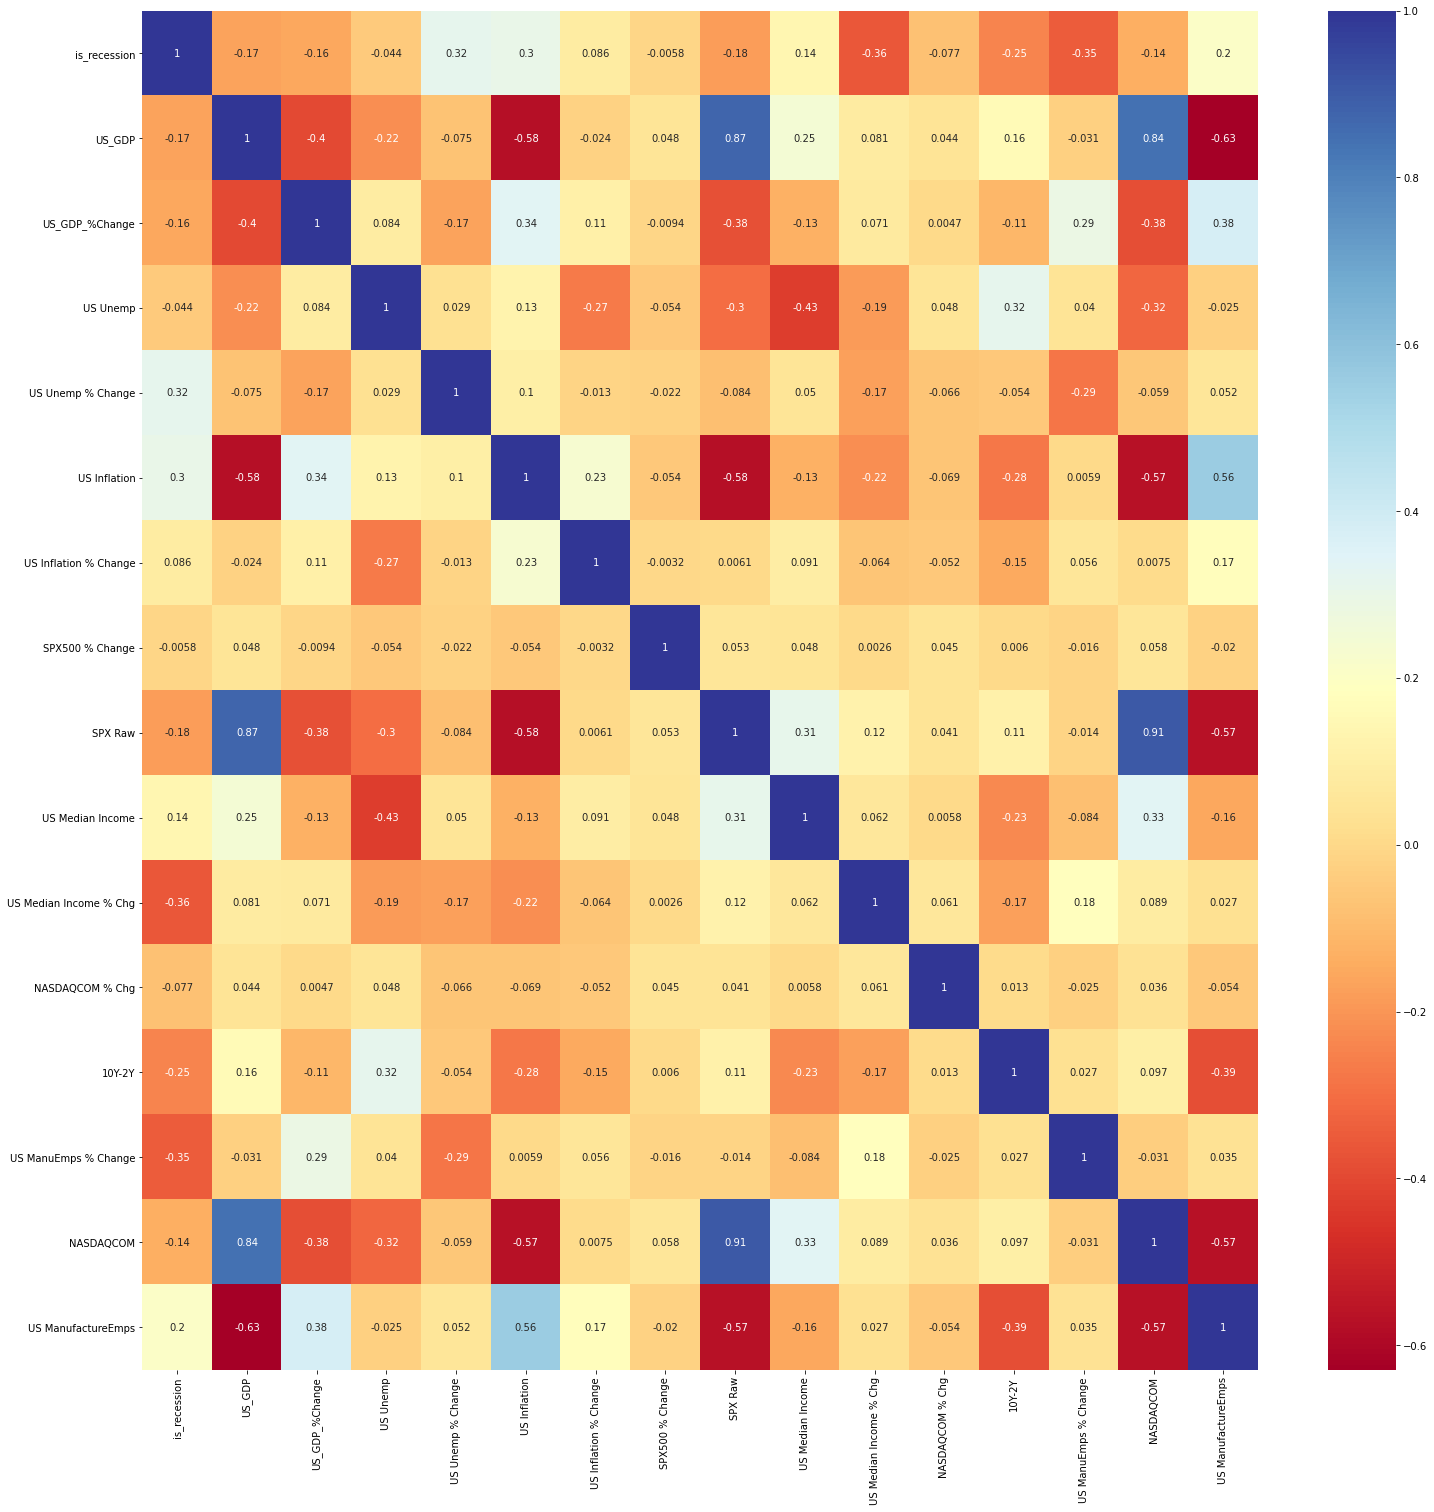

In [32]:
corr = df_merged.corr(method='kendall')
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True, cmap="RdYlBu")

## Feature Selection

In [33]:
percent_chg_col = {'US_GDP_%Change', 'US Unemp % Change', 'US Inflation % Change', 
                   'SPX500 % Change', 'NASDAQCOM % Chg', 'US ManuEmps % Change', 'US Median Income % Chg'}
num_col = {'US_GDP', 'US Unemp', 'US Inflation', 'US Median Income', '10Y-2Y', 'US ManufactureEmps', 'SPX Raw', 'NASDAQCOM'}
macro_col = {'US_GDP', 'US Unemp', 'US Inflation', '10Y-2Y', 'US ManufactureEmps', 'US_GDP_%Change', 
             'US Unemp % Change', 'US Inflation % Change', 'US ManuEmps % Change'}
micro_col = {'SPX500 % Change', 'NASDAQCOM % Chg', 'US Median Income', 'US Median Income % Chg', 'SPX Raw', 'NASDAQCOM'}
target = {'is_recession'}

### Micro: Percent & Raw

In [34]:
micro_pct = df_merged[list(micro_col - num_col)]
micro_raw = df_merged[list(micro_col - percent_chg_col)]
micro_pct.columns, micro_raw.columns

(Index(['SPX500 % Change', 'US Median Income % Chg', 'NASDAQCOM % Chg'], dtype='object'),
 Index(['NASDAQCOM', 'US Median Income', 'SPX Raw'], dtype='object'))

### Macro: Percent & Raw

In [35]:
macro_pct = df_merged[list(macro_col - num_col)]
macro_raw = df_merged[list(macro_col - percent_chg_col)]
macro_pct.columns, macro_raw.columns

(Index(['US Inflation % Change', 'US_GDP_%Change', 'US ManuEmps % Change',
        'US Unemp % Change'],
       dtype='object'),
 Index(['10Y-2Y', 'US ManufactureEmps', 'US Unemp', 'US_GDP', 'US Inflation'], dtype='object'))

### All: Percent & Raw

In [36]:
all_pct = df_merged[list(percent_chg_col)]
all_raw = df_merged[list(num_col)]
all_pct.columns, all_raw.columns

(Index(['US Inflation % Change', 'NASDAQCOM % Chg', 'US Unemp % Change',
        'US_GDP_%Change', 'SPX500 % Change', 'US Median Income % Chg',
        'US ManuEmps % Change'],
       dtype='object'),
 Index(['10Y-2Y', 'US ManufactureEmps', 'US Median Income', 'SPX Raw',
        'US Unemp', 'US_GDP', 'NASDAQCOM', 'US Inflation'],
       dtype='object'))

### All: ANOVA Selection

In [37]:
from sklearn.feature_selection import SelectKBest, f_classif

def get_k_best(X: pd.DataFrame, y: pd.DataFrame, k: int = 5) -> list:
    """ Takes in a data frame and reports the top K features """
    fit = SelectKBest(score_func=f_classif, k=k).fit(np.array(X), np.array(y).reshape(y.shape[0]))
    values = fit.transform(np.array(X))
    frozen = [frozenset(v) for v in values.T]
    labels = list(label for label, values in X.iteritems() if frozenset(values) in frozen)
    assert len(labels) == k
    return labels

anova_pct_feat = get_k_best(all_pct, df_merged[target])
anova_raw_feat = get_k_best(all_raw, df_merged[target])
anova_pct_feat, anova_raw_feat

(['NASDAQCOM % Chg',
  'US Unemp % Change',
  'US_GDP_%Change',
  'US Median Income % Chg',
  'US ManuEmps % Change'],
 ['10Y-2Y', 'US ManufactureEmps', 'SPX Raw', 'US_GDP', 'US Inflation'])

In [38]:
anova_pct = all_pct[anova_pct_feat]
anova_pct

,NASDAQCOM % Chg,US Unemp % Change,US_GDP_%Change,US Median Income % Chg,US ManuEmps % Change
1970-01-01,-0.002872,0.114286,0.012573,-0.007593,-0.003300
1970-02-01,-0.002872,0.076923,0.012573,-0.007593,-0.003419
1970-03-01,-0.002872,0.047619,0.012573,-0.007593,-0.000054
1970-04-01,-0.002872,0.045455,0.015387,-0.007593,-0.008333
1970-05-01,-0.002872,0.043478,0.015387,-0.007593,-0.009776
...,...,...,...,...,...
2020-05-01,0.154472,-0.095238,-0.094662,0.068077,0.020890
2020-06-01,0.154472,-0.165414,-0.094662,0.068077,0.028391
2020-07-01,0.053048,-0.081081,0.083863,0.068077,0.003399
2020-08-01,0.068250,-0.176471,0.083863,0.068077,0.002479


In [39]:
anova_raw = all_raw[anova_raw_feat]
anova_raw

,10Y-2Y,US ManufactureEmps,SPX Raw,US_GDP,US Inflation
1970-01-01,0.344628,18424.0,591.412857,1051.200,5.838255
1970-02-01,0.344628,18361.0,90.332857,1051.200,5.838255
1970-03-01,0.344628,18360.0,87.164211,1051.200,5.838255
1970-04-01,0.344628,18207.0,88.652381,1067.375,5.838255
1970-05-01,0.344628,18029.0,85.952272,1067.375,5.838255
...,...,...,...,...,...
2020-05-01,0.432857,11729.0,2761.975226,19520.114,1.812210
2020-06-01,0.503500,12062.0,2919.608484,19520.114,1.812210
2020-07-01,0.543636,12103.0,3104.660933,21157.122,1.812210
2020-08-01,0.475455,12133.0,3207.619096,21157.122,1.812210


### All: PCA

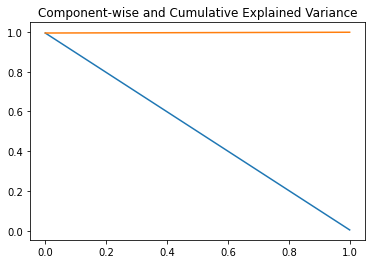

array([[-0.02466255,  0.1113691 ],
       [-0.02463566,  0.07439871],
       [-0.02461427,  0.04524438],
       ...,
       [-0.35130741, -0.09269643],
       [-0.35126006, -0.18896133],
       [-0.35138243, -0.07685113]])

In [40]:
from sklearn.decomposition import PCA

def get_n_components(X: pd.DataFrame, n: int = 5) -> np.ndarray:
    pca = PCA(n_components=n)
    pca_result = pca.fit_transform(X.values)
    plt.plot(range(n), pca.explained_variance_ratio_)
    plt.plot(range(n), np.cumsum(pca.explained_variance_ratio_))
    plt.title("Component-wise and Cumulative Explained Variance")
    plt.show()
    return pca_result

pca_pct = get_n_components(all_pct, n = 2)
pca_pct

*The above shows that 2 components explains 100% of the variance*

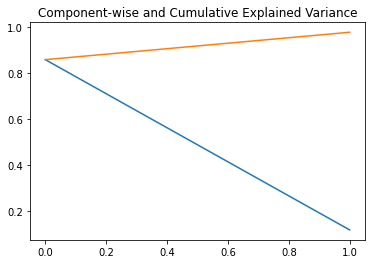

array([[-7579.20744518,  3310.86292383],
       [-7614.23779366,  3275.81075653],
       [-7614.27079305,  3275.44915035],
       ...,
       [16642.76153371,  6167.76300593],
       [16825.38667029,  6301.57857669],
       [17021.87079042,  6455.43779043]])

In [41]:
pca_raw = get_n_components(all_raw, n = 2)
pca_raw

In [42]:
len(pca_raw)

609

### All: Corr Selection

array(['US Median Income % Chg', 'US ManuEmps % Change',
       'US Unemp % Change', 'US_GDP_%Change', 'US Inflation % Change'],
      dtype=object)

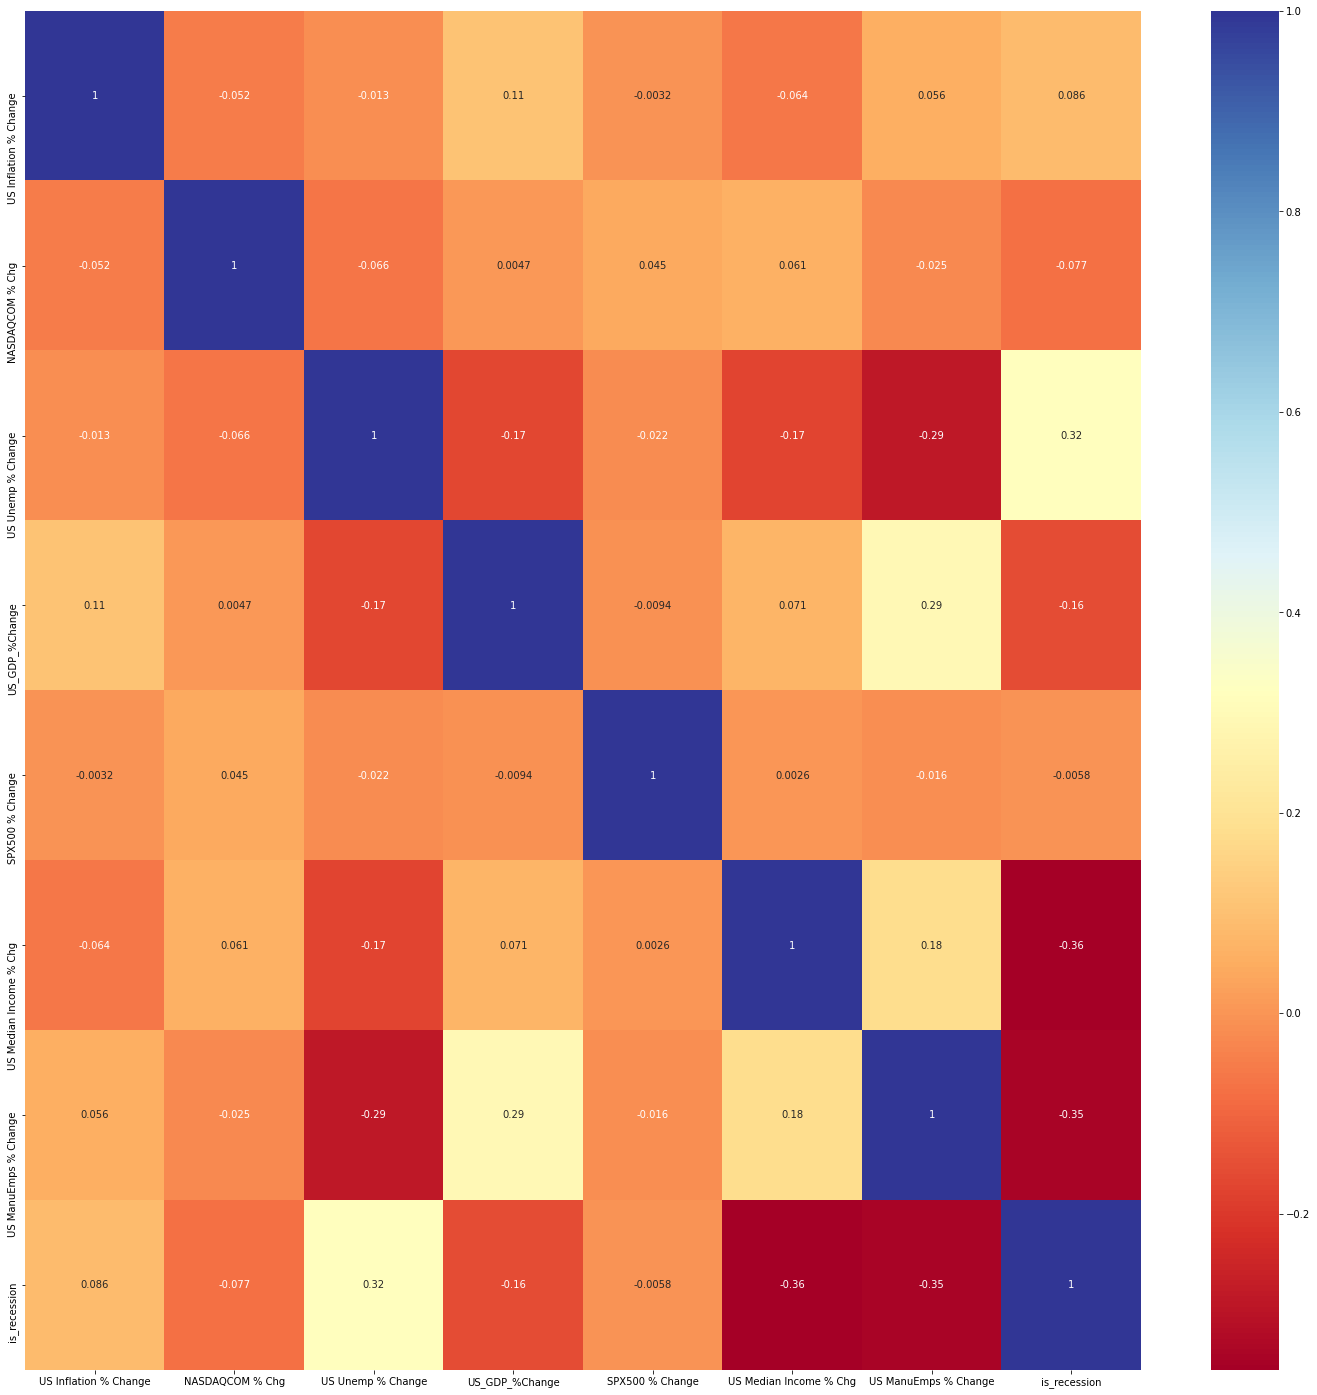

In [43]:
def get_k_corr(df: pd.DataFrame, y: pd.DataFrame, col: str, k: int = 5) -> None:
    """ Plots the correlation matrix and returns the theoretically highest values for the target """
    df = pd.merge(all_pct,df_merged[target],left_index=True,right_index=True,how='inner')
    corr = df.corr(method='kendall')
    ktau_cols = np.array(corr[col].abs().sort_values(ascending=False)[1:51].index)
    plt.figure(figsize=(25,25))
    sns.heatmap(corr, annot=True, cmap="RdYlBu")
    return ktau_cols[:k]

corr_pct_feats = get_k_corr(all_pct, df_merged[target], 'is_recession')
corr_pct_feats

array(['US Median Income % Chg', 'US ManuEmps % Change',
       'US Unemp % Change', 'US_GDP_%Change', 'US Inflation % Change'],
      dtype=object)

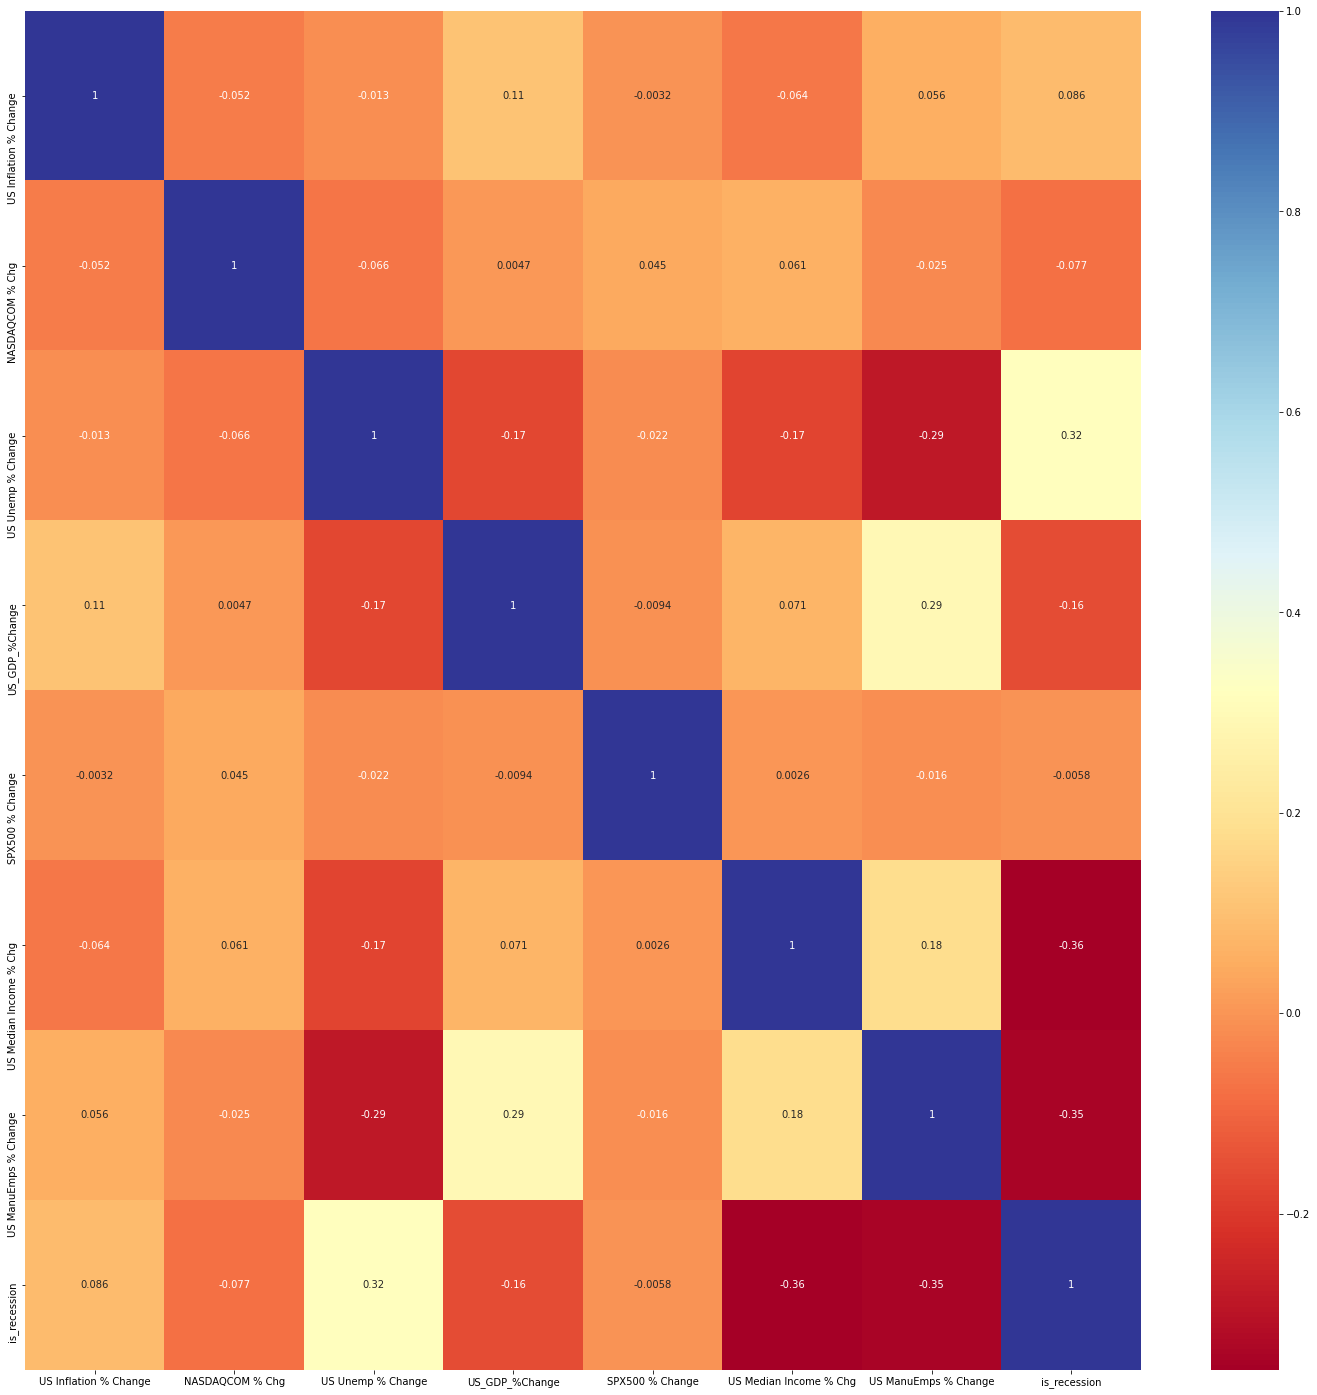

In [44]:
corr_raw_feats = get_k_corr(all_raw, df_merged[target], 'is_recession')
corr_raw_feats

In [45]:
corr_raw = df_merged[corr_raw_feats]
corr_raw

,US Median Income % Chg,US ManuEmps % Change,US Unemp % Change,US_GDP_%Change,US Inflation % Change
1970-01-01,-0.007593,-0.003300,0.114286,0.012573,0.068810
1970-02-01,-0.007593,-0.003419,0.076923,0.012573,0.068810
1970-03-01,-0.007593,-0.000054,0.047619,0.012573,0.068810
1970-04-01,-0.007593,-0.008333,0.045455,0.015387,0.068810
1970-05-01,-0.007593,-0.009776,0.043478,0.015387,0.068810
...,...,...,...,...,...
2020-05-01,0.068077,0.020890,-0.095238,-0.094662,-0.258076
2020-06-01,0.068077,0.028391,-0.165414,-0.094662,-0.258076
2020-07-01,0.068077,0.003399,-0.081081,0.083863,-0.258076
2020-08-01,0.068077,0.002479,-0.176471,0.083863,-0.258076


In [46]:
corr_pct = df_merged[corr_pct_feats]
corr_pct

,US Median Income % Chg,US ManuEmps % Change,US Unemp % Change,US_GDP_%Change,US Inflation % Change
1970-01-01,-0.007593,-0.003300,0.114286,0.012573,0.068810
1970-02-01,-0.007593,-0.003419,0.076923,0.012573,0.068810
1970-03-01,-0.007593,-0.000054,0.047619,0.012573,0.068810
1970-04-01,-0.007593,-0.008333,0.045455,0.015387,0.068810
1970-05-01,-0.007593,-0.009776,0.043478,0.015387,0.068810
...,...,...,...,...,...
2020-05-01,0.068077,0.020890,-0.095238,-0.094662,-0.258076
2020-06-01,0.068077,0.028391,-0.165414,-0.094662,-0.258076
2020-07-01,0.068077,0.003399,-0.081081,0.083863,-0.258076
2020-08-01,0.068077,0.002479,-0.176471,0.083863,-0.258076


# Everything

In [47]:
everything = df_merged.drop(columns=target)
everything

,US_GDP,US_GDP_%Change,US Unemp,US Unemp % Change,US Inflation,US Inflation % Change,SPX500 % Change,SPX Raw,US Median Income,US Median Income % Chg,NASDAQCOM % Chg,10Y-2Y,US ManuEmps % Change,NASDAQCOM,US ManufactureEmps
1970-01-01,1051.200,0.012573,3.9,0.114286,5.838255,0.068810,-0.000626,591.412857,60120.5,-0.007593,-0.002872,0.344628,-0.003300,1281.277182,18424.0
1970-02-01,1051.200,0.012573,4.2,0.076923,5.838255,0.068810,-0.000626,90.332857,60120.5,-0.007593,-0.002872,0.344628,-0.003419,1281.277182,18361.0
1970-03-01,1051.200,0.012573,4.4,0.047619,5.838255,0.068810,-0.000626,87.164211,60120.5,-0.007593,-0.002872,0.344628,-0.000054,1281.277182,18360.0
1970-04-01,1067.375,0.015387,4.6,0.045455,5.838255,0.068810,0.004909,88.652381,60120.5,-0.007593,-0.002872,0.344628,-0.008333,1281.277182,18207.0
1970-05-01,1067.375,0.015387,4.8,0.043478,5.838255,0.068810,-0.000981,85.952272,60120.5,-0.007593,-0.002872,0.344628,-0.009776,1281.277182,18029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,19520.114,-0.094662,13.3,-0.095238,1.812210,-0.258076,-0.028059,2761.975226,68703.0,0.068077,0.154472,0.432857,0.020890,8292.407762,11729.0
2020-06-01,19520.114,-0.094662,11.1,-0.165414,1.812210,-0.258076,0.003751,2919.608484,68703.0,0.068077,0.154472,0.503500,0.028391,9105.655650,12062.0
2020-07-01,21157.122,0.083863,10.2,-0.081081,1.812210,-0.258076,0.005022,3104.660933,68703.0,0.068077,0.053048,0.543636,0.003399,9839.970955,12103.0
2020-08-01,21157.122,0.083863,8.4,-0.176471,1.812210,-0.258076,0.005022,3207.619096,68703.0,0.068077,0.068250,0.475455,0.002479,10499.862909,12133.0


In [48]:
normalized_dfs = [micro_raw, macro_raw, all_raw, corr_raw, anova_raw]

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
micro_raw = scaler.fit_transform(micro_raw)
macro_raw = scaler.fit_transform(macro_raw)
all_raw = scaler.fit_transform(all_raw)
corr_raw = scaler.fit_transform(corr_raw)
anova_raw = scaler.fit_transform(anova_raw)

In [50]:
all_models = [(micro_pct, 'Micro Pct'), (micro_raw, 'Micro Raw'), (macro_pct, 'Macro Pct'), 
              (macro_raw, 'Macro Raw'), (all_pct, 'All Pct'), (all_raw, 'All Raw'), (anova_pct, 'ANOVA Pct'), 
              (anova_raw, 'ANOVA Raw'), (pca_raw, 'PCA Raw'), (pca_pct, 'PCA Pct'), 
              (corr_pct, 'Corr Pct'), (corr_raw, 'Corr Raw')]
len(all_models)

model_scores_data = [["Model", "Data Subset", "Feature Selection Method", "True Positive", "False Positive", "True Negative", "False Negative", "Cross Validation Mean", "Cross Validation STD", "Test Accuracy"]]

## Models

In [51]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split

## y will be target variable
y = np.array(df_merged[target])
y = y.reshape(y.shape[0])
all_train_test=[]
for model, name in all_models:
    # Splits data into training and testing sets
    all_train_test.append(train_test_split(np.array(model), y, test_size=0.2, random_state=5)+[name])
# Splits the data in 10, such that each fold has the same class distribution of the whole data set, and repeats 3 times.
cross=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

**Logistic Regression Models**

Score for Micro Pct model is 0.81859410430839 (0.022723960202735788) for cross validated training data.
Score for Micro Pct model is 0.8524590163934426 for test data.
Accuracy of 22 true recessions: 0.18181818181818182


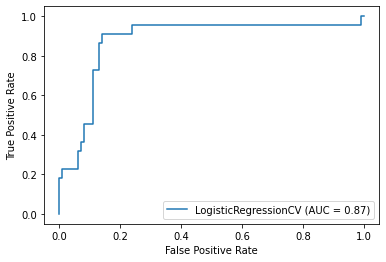

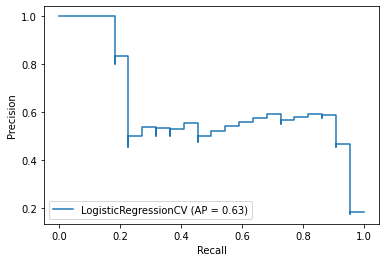

Score for Micro Raw model is 0.8117772108843538 (0.008993226384682293) for cross validated training data.
Score for Micro Raw model is 0.819672131147541 for test data.
Accuracy of 22 true recessions: 0.0


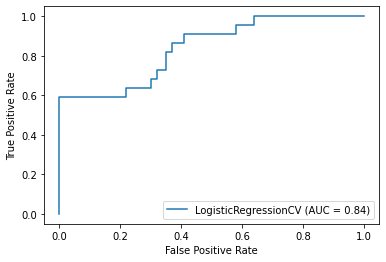

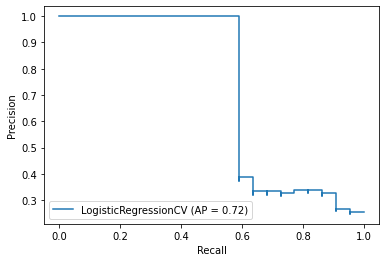

Score for Macro Pct model is 0.8775085034013604 (0.033154061095533253) for cross validated training data.
Score for Macro Pct model is 0.860655737704918 for test data.
Accuracy of 22 true recessions: 0.4090909090909091


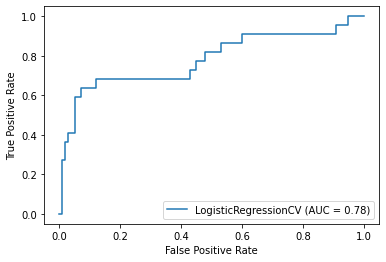

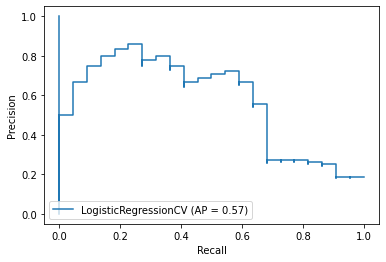

Score for Macro Raw model is 0.8467120181405896 (0.03156979293383636) for cross validated training data.
Score for Macro Raw model is 0.8770491803278688 for test data.
Accuracy of 22 true recessions: 0.5


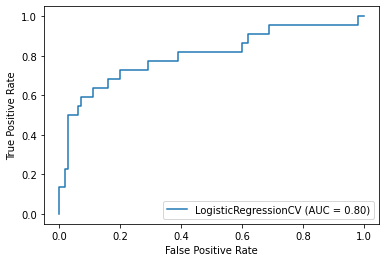

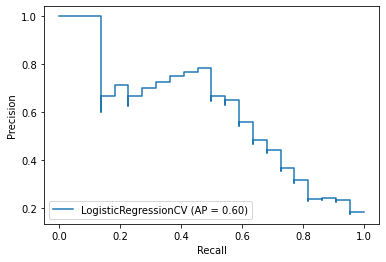

Score for All Pct model is 0.8945719954648526 (0.03785374594946328) for cross validated training data.
Score for All Pct model is 0.8852459016393442 for test data.
Accuracy of 22 true recessions: 0.5


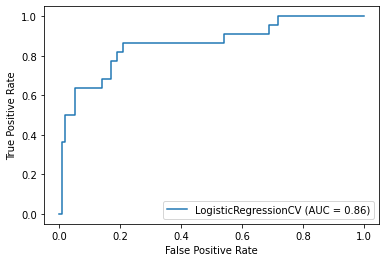

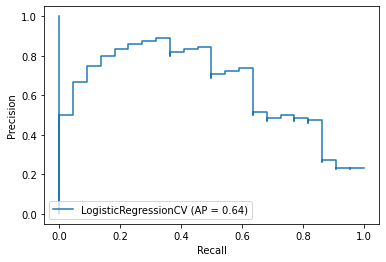

Score for All Raw model is 0.848795351473923 (0.03217922035885149) for cross validated training data.
Score for All Raw model is 0.8770491803278688 for test data.
Accuracy of 22 true recessions: 0.5


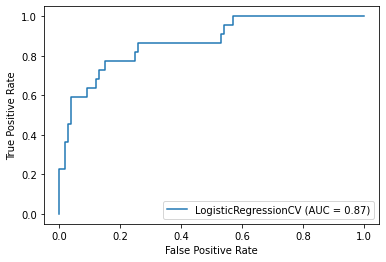

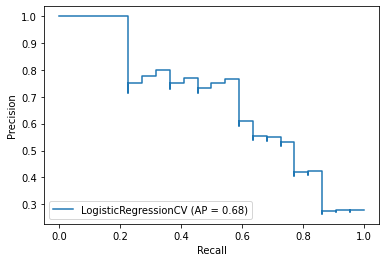

Score for ANOVA Pct model is 0.8939058956916099 (0.036383021656237004) for cross validated training data.
Score for ANOVA Pct model is 0.8934426229508197 for test data.
Accuracy of 22 true recessions: 0.5


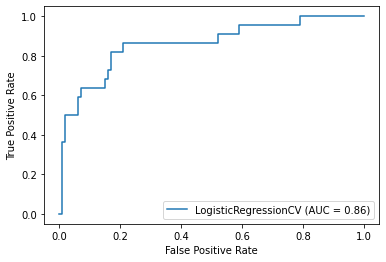

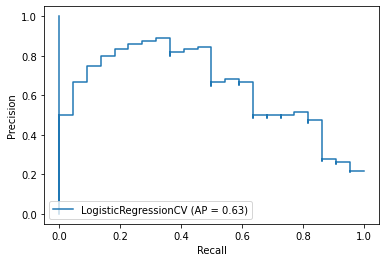

Score for ANOVA Raw model is 0.8521683673469388 (0.03106325416204576) for cross validated training data.
Score for ANOVA Raw model is 0.8770491803278688 for test data.
Accuracy of 22 true recessions: 0.5


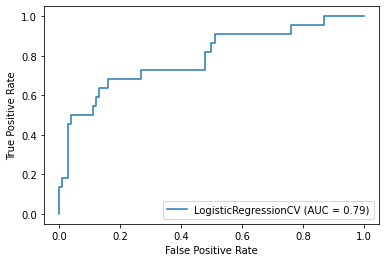

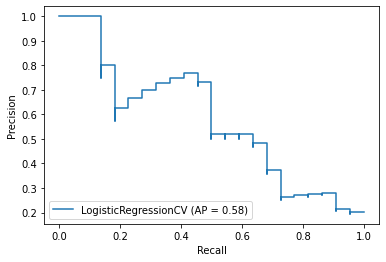

Score for PCA Raw model is 0.8110969387755103 (0.007768056111523024) for cross validated training data.
Score for PCA Raw model is 0.819672131147541 for test data.
Accuracy of 22 true recessions: 0.0


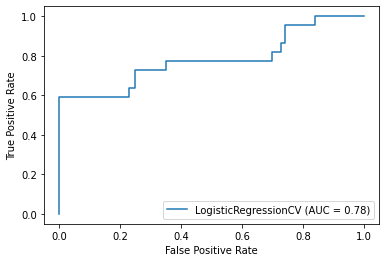

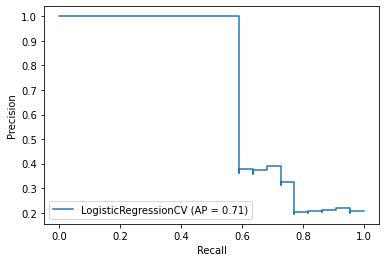

Score for PCA Pct model is 0.848044217687075 (0.029260145184625077) for cross validated training data.
Score for PCA Pct model is 0.8852459016393442 for test data.
Accuracy of 22 true recessions: 0.45454545454545453


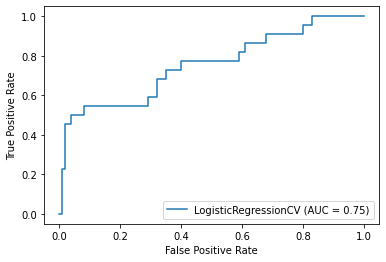

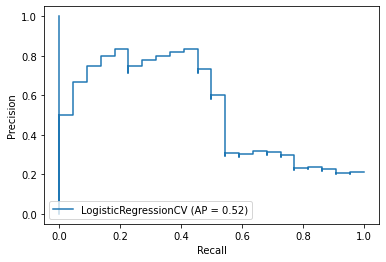

Score for Corr Pct model is 0.8918225623582767 (0.0356411022897823) for cross validated training data.
Score for Corr Pct model is 0.8852459016393442 for test data.
Accuracy of 22 true recessions: 0.5454545454545454


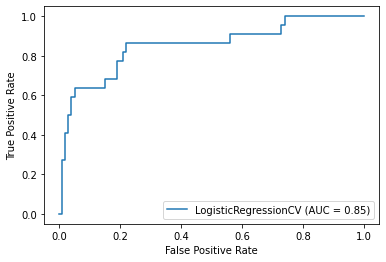

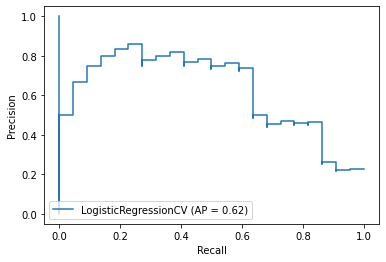

Score for Corr Raw model is 0.8884070294784581 (0.03552307721559614) for cross validated training data.
Score for Corr Raw model is 0.8852459016393442 for test data.
Accuracy of 22 true recessions: 0.5


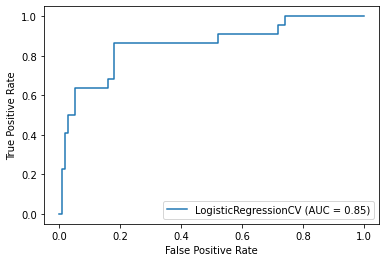

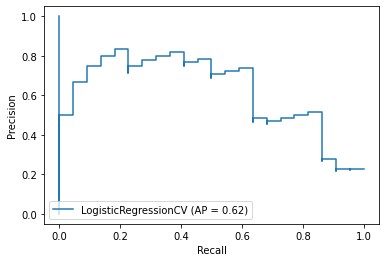

In [52]:
## Example PCA Usage
#### Notice that there is no need to convert it to a ndarray since it is already in that form
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve

def logisticModels(X_train, X_test, y_train, y_test, name):
    lr = LogisticRegressionCV(max_iter=1000, random_state=0)
    accuracy=cross_val_score(lr, X_train, y_train, scoring="accuracy", cv=cross)
    lr.fit(X_train, y_train)
    print(f'Score for {name} model is {np.mean(accuracy)} ({np.std(accuracy)}) for cross validated training data.')
    print(f'Score for {name} model is {lr.score(X_test, y_test)} for test data.')
    cm = confusion_matrix(y_test, lr.predict(X_test))
    correct = cm[1][1]
    total = correct + cm[1][0]
    print(f'Accuracy of {total} true recessions: {correct/total}')
    plot_roc_curve(lr, X_test, y_test)
    plot_precision_recall_curve(lr, X_test, y_test)
    plt.show()
    data_sub, fsm = name.split()
    model_scores_data.append(["Logistic Regression", data_sub, fsm, cm[1][1], cm[0][1], cm[0][0], cm[1][0], np.mean(accuracy), np.std(accuracy), correct/total])

for i in all_train_test:
    logisticModels(*i)

**Random Forest Models**

Score for Micro Pct model is 0.9431689342403627 (0.028897249801972762) for cross validated training data.
Score for Micro Pct model is 0.9672131147540983 for test data.
Accuracy of 22 true recessions predicted: 0.9090909090909091


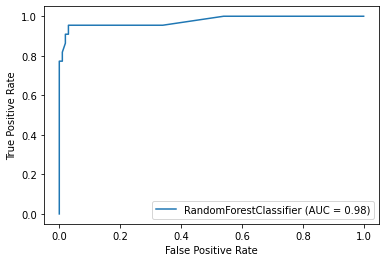

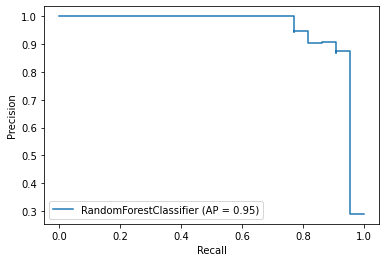

Score for Micro Raw model is 0.9692176870748299 (0.02746844340785997) for cross validated training data.
Score for Micro Raw model is 0.9754098360655737 for test data.
Accuracy of 22 true recessions predicted: 0.9090909090909091


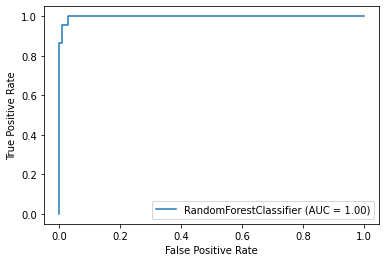

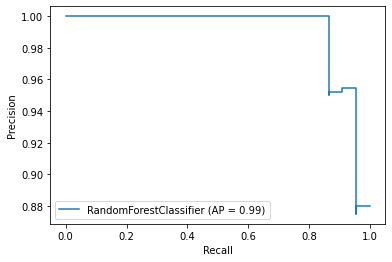

Score for Macro Pct model is 0.8966269841269842 (0.04082765298565811) for cross validated training data.
Score for Macro Pct model is 0.9098360655737705 for test data.
Accuracy of 22 true recessions predicted: 0.5909090909090909


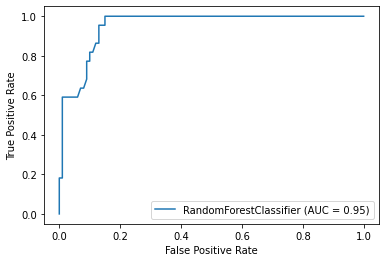

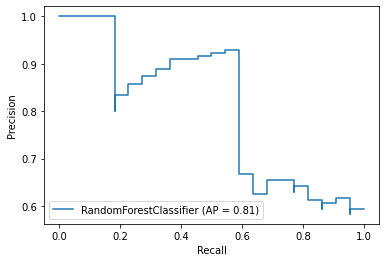

Score for Macro Raw model is 0.9808248299319728 (0.02051516438685476) for cross validated training data.
Score for Macro Raw model is 0.9836065573770492 for test data.
Accuracy of 22 true recessions predicted: 0.9090909090909091


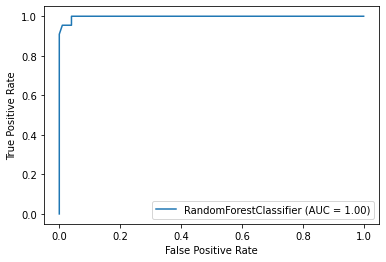

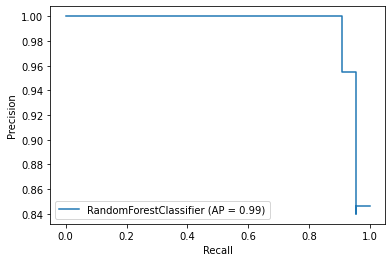

Score for All Pct model is 0.9713010204081632 (0.022809030181691173) for cross validated training data.
Score for All Pct model is 0.9836065573770492 for test data.
Accuracy of 22 true recessions predicted: 0.9545454545454546


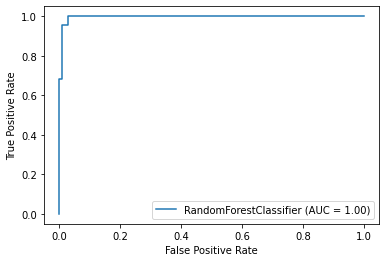

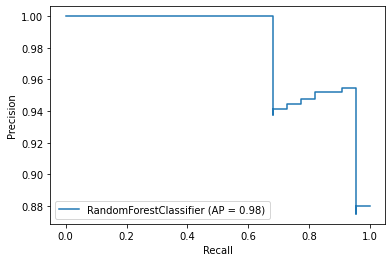

Score for All Raw model is 0.989030612244898 (0.01656032411887453) for cross validated training data.
Score for All Raw model is 0.9918032786885246 for test data.
Accuracy of 22 true recessions predicted: 0.9545454545454546


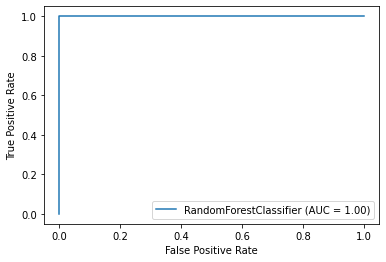

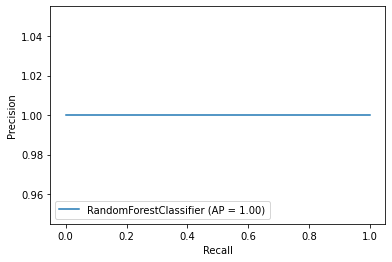

Score for ANOVA Pct model is 0.9514314058956916 (0.02974746234721978) for cross validated training data.
Score for ANOVA Pct model is 0.9836065573770492 for test data.
Accuracy of 22 true recessions predicted: 0.9545454545454546


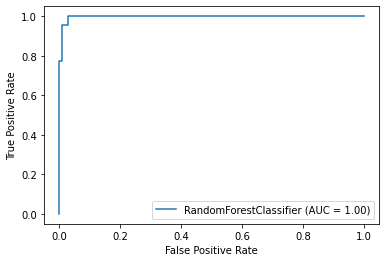

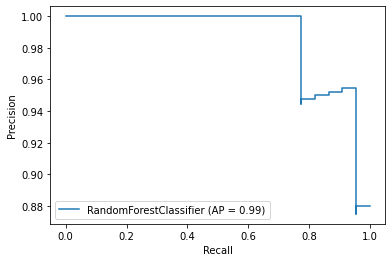

Score for ANOVA Raw model is 0.9774092970521543 (0.0185978846538728) for cross validated training data.
Score for ANOVA Raw model is 0.9836065573770492 for test data.
Accuracy of 22 true recessions predicted: 0.9545454545454546


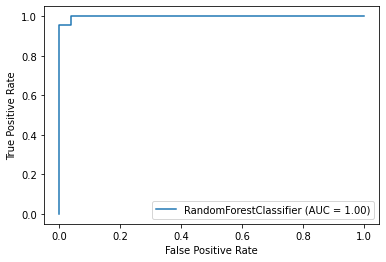

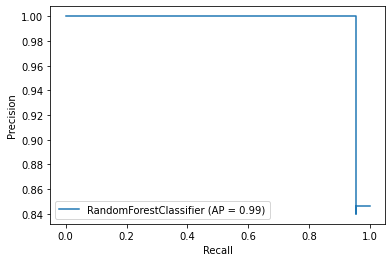

Score for PCA Raw model is 0.9856575963718821 (0.017648717966164258) for cross validated training data.
Score for PCA Raw model is 0.9918032786885246 for test data.
Accuracy of 22 true recessions predicted: 0.9545454545454546


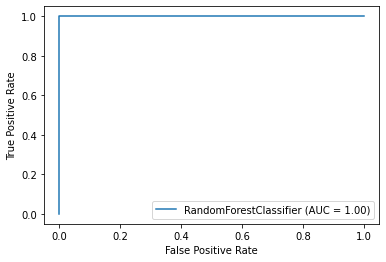

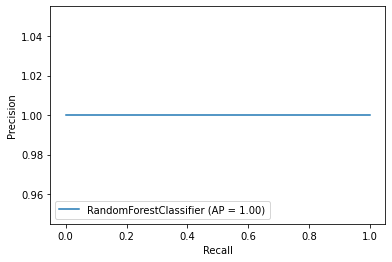

Score for PCA Pct model is 0.8829365079365079 (0.04022737011474516) for cross validated training data.
Score for PCA Pct model is 0.8770491803278688 for test data.
Accuracy of 22 true recessions predicted: 0.5


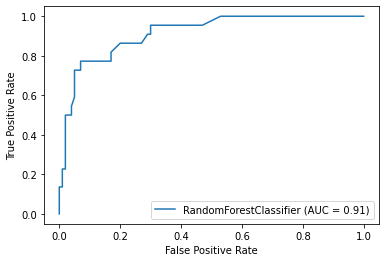

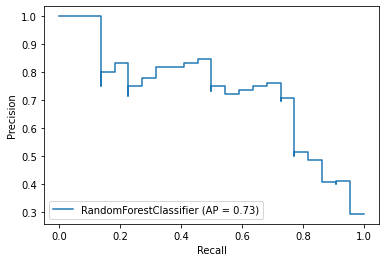

Score for Corr Pct model is 0.9760487528344672 (0.02657190095422728) for cross validated training data.
Score for Corr Pct model is 0.9918032786885246 for test data.
Accuracy of 22 true recessions predicted: 1.0


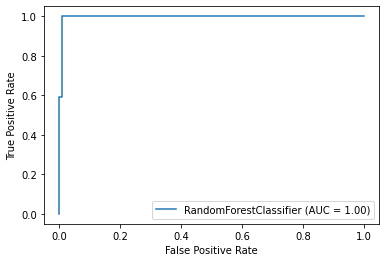

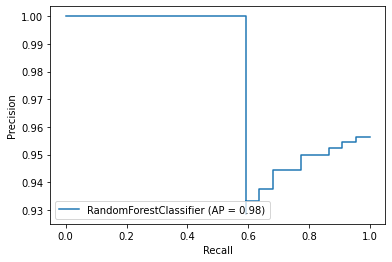

Score for Corr Raw model is 0.9787698412698411 (0.025805390914215937) for cross validated training data.
Score for Corr Raw model is 0.9918032786885246 for test data.
Accuracy of 22 true recessions predicted: 1.0


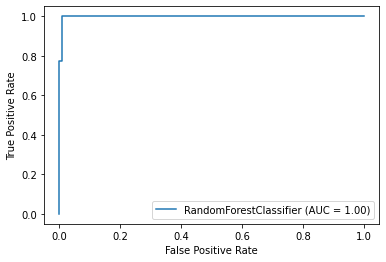

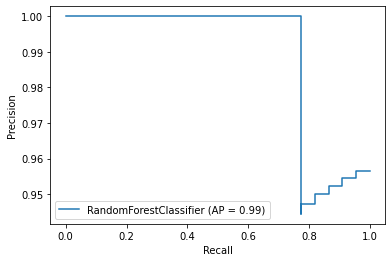

In [53]:
from sklearn.ensemble import RandomForestClassifier

def randomForestModels(X_train, X_test, y_train, y_test, name):
    rf = RandomForestClassifier()
    accuracy=cross_val_score(rf, X_train, y_train, scoring="accuracy", cv=cross)
    rf.fit(X_train, y_train)
    print(f'Score for {name} model is {np.mean(accuracy)} ({np.std(accuracy)}) for cross validated training data.')
    print(f'Score for {name} model is {rf.score(X_test, y_test)} for test data.')
    cm = confusion_matrix(y_test, rf.predict(X_test))
    correct = cm[1][1]
    total = correct + cm[1][0]
    print(f'Accuracy of {total} true recessions predicted: {correct/total}')
    plot_roc_curve(rf, X_test, y_test)
    plot_precision_recall_curve(rf, X_test, y_test)
    plt.show()
    data_sub, fsm = name.split()
    model_scores_data.append(["Random Forest Classifier", data_sub, fsm, cm[1][1], cm[0][1], cm[0][0], cm[1][0], np.mean(accuracy), np.std(accuracy), correct/total])

for i in all_train_test:
    randomForestModels(*i)

**SVM Models**

In [54]:
# code changes on 1206 
# ref https://towardsdatascience.com/support-vector-machines-svm-c9ef22815589 
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# function used to get the C and gamma values for the train and test vectors
# svm is well suited for non linear time series [multivariate TSC] data [ smaller dataset ]
# https://tomaxent.com/2018/04/27/Micro-and-Macro-average-of-Precision-Recall-and-F-Score/#:~:text=The%20Macro%2Daverage%20F%2DScore,mean%20of%20these%20two%20figures.&text=Macro%2Daverage%20method%20can%20be,specific%20decision%20with%20this%20average.
# compute the best C and Gamma value for the train data 
# fit the model 
# compute the f1 score for the test data 
# choose the ar
def compute_C_Gamma_RBF(X_train, y_train, X_test, y_test,
                            hprange_C, hprange_gamma):
    # intialize the accuracy_matrix dim based on both C and gamma range  
    accuracy_matrix = np.zeros((hprange_C.shape[0],hprange_gamma.shape[0]))
    # loop through both C and gamma range values 
    for c_index,C in enumerate(hprange_C):
        for gamma_index,gamma in enumerate(hprange_gamma):
            SVM_model_RBF = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            SVM_model_RBF.fit(X_train, y_train)
            accuracy_matrix[c_index,gamma_index] = f1_score(y_test ,SVM_model_RBF.predict(X_test), average='macro')
            #print ('argmax value of  accruacy mat %s ' %(np.argmax(accuracy_matrix)))
    C_index_value, gamma_index_value = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape) 
    #print ('C indices and gamma_indices  values are %s %s ' %(C_ind, gamma_ind ))
    return hprange_C[C_index_value], hprange_gamma[gamma_index_value]

In [55]:
# code changes on 1206 
from sklearn.model_selection import GridSearchCV

# need to check the computed C and gamma using grid search cross validation for thr train data 
#def  compute_C_Gamma_RBF_GSV (X_train, y_train,hprange_C, hprange_gamma):
def  compute_C_Gamma_RBF_GSV (X_train, y_train,hprange_C, hprange_gamma):
    # instantiate the model for the X_train, y_train with the computed C and gamma values  
    SVM_SVC_model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    C_param_range = np.array([10 , 0.07, 7,0.06,0.0006,700,650.5 , 0.007 ,0.029593 , 0.45, 0.003300 , 1281 ,19424 ]  )
    Gamma_param_range =np.array([10 , 0.07, 7,0.06,0.0006,700,650.5 , 0.007 ,0.029593 , 0.45, 0.003300 , 1281 ,19424 ] )
    # call the 
    GSCV_SVM_param_grid = [{'kernel':['rbf'],'gamma':Gamma_param_range,
                 'C':C_param_range }]
    GSCV_SVM_model = GridSearchCV(SVM_SVC_model,GSCV_SVM_param_grid,cv=5,n_jobs=-1)
    GSCV_SVM_model.fit(X_train,y_train)
    print (' the best C and gamma parameter values are %s '  % (GSCV_SVM_model.best_params_) ) 
    print (' accruacy of svm using gscv %s '  % (GSCV_SVM_model.best_score_*100) ) 
    return GSCV_SVM_model.best_params_ ,GSCV_SVM_model.best_score_*100

In [56]:
# code changes on 1206 
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import svm
# set the gamma and C value 
# driver to check the hyperparameters value set for kernel RBF 
C_param_range = np.array([10 , 0.07, 7,0.06,0.0006,700,650.5 , 0.007 ,0.029593 , 0.45, 0.003300 , 1281 ,19424 ]  )
Gamma_param_range =np.array([10 , 0.07, 7,0.06,0.0006,700,650.5 , 0.007 ,0.029593 , 0.45, 0.003300 , 1281 ,19424 ] )
X_train, X_test, y_train, y_test = train_test_split(np.array(model), y, test_size=0.2, random_state=5)
C, gamma = compute_C_Gamma_RBF(X_train, y_train, X_test, y_test, C_param_range, Gamma_param_range)
print ('best value of C and Gamma for test data  %d %d ' %(C ,gamma) )

best value of C and Gamma for test data  700 0 


In [ ]:
# code changes on 1206
# split the train and test data 
# prepare the gamma and C parameters for RBF 
# instanitiate SVM with RBF kernal and C and Gamma values 
# fit the SVM model for the train data 
# get the confusion matrix for actual and predicted one 
# plot the roc 
# call the svm model for all the dataset

def svmModels(X_train, X_test, y_train, y_test, name):
    C_param_range = np.array([10 , 0.07, 7,0.06,0.0006,700,650.5 , 0.007 ,0.029593 , 0.45, 0.003300 , 1281 ,19424 ]  )
    Gamma_param_range =np.array([10 , 0.07, 7,0.06,0.0006,700,650.5 , 0.007 ,0.029593 , 0.45, 0.003300 , 1281 ,19424 ] )
    C, gamma = compute_C_Gamma_RBF(X_train, y_train, X_test, y_test, C_param_range, Gamma_param_range)
    # instantiate the model for the X_train, y_train with the computed C and gamma values  
    SVM_model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    accuracy=cross_val_score(SVM_model, X_train, y_train, scoring="accuracy", cv=cross)
    SVM_model.fit(X_train, y_train)
    print(f'Score for {name} model is {np.mean(accuracy)} ({np.std(accuracy)}) for cross validated training data.')
    print(f'Score for {name} model is {SVM_model.score(X_test, y_test)} for test data.')
    cm = confusion_matrix(y_test, SVM_model.predict(X_test))
    correct = cm[1][1]
    total = correct + cm[1][0]
    print(f'Accuracy of {total} true recessions predicted: {correct/total}')
    plot_roc_curve(SVM_model, X_test, y_test)
    plot_precision_recall_curve(SVM_model, X_test, y_test)
    plt.show()
    data_sub, fsm = name.split()
    model_scores_data.append(["SVM", data_sub, fsm, cm[1][1], cm[0][1], cm[0][0], cm[1][0], np.mean(accuracy), np.std(accuracy), correct/total])

for i in all_train_test:
    svmModels(*i)

## Reporting

In [ ]:
model_scores=pd.DataFrame(model_scores_data[1:], columns=model_scores_data[0])
model_scores.sort_values(by=[model_scores_data[0][-1]], ascending=False)

## Canada Data

In [ ]:
canada_recession = get_fred_series('CANRECDM', '1970-01-01', 'Recession')
canada_gdp = get_fred_series('MKTGDPCAA646NWDB', '1970-01-01', 'GDP')
canada_gdp_pctcg = get_fred_series('MKTGDPCAA646NWDB', '1970-01-01', 'GDP_%Change', pct_change=True)
unemp = get_fred_series('LRUNTTTTCAM156S', '1970-01-01', 'Unemp')
unemp = unemp.iloc[::3, :]
unemp_pct = get_fred_series('LRUNTTTTCAM156S', '1970-01-01', 'Unemp % Change', pct_change=True, periods=3).iloc[::3, :]
nascom_pct = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM % Chg', pct_change=True, freq='Q')
nascom_pct = nascom_pct.loc[nascom_pct['NASDAQCOM % Chg'].notnull() == True]
nascom_pct.index = nascom_pct.index + pd.Timedelta('1 day')
bond10y = get_fred_series('IRLTLT01CAM156N', '1970-01-01', '10Y-bonds')
canada_inflation = get_fred_series('FPCPITOTLZGCAN', '1970-01-01', 'Inflation')
canada_employees = get_fred_series('LFEAMNTTCAM647S', '1970-01-01', 'ManufactureEmps')
canada_employees_chg = get_fred_series('LFEAMNTTCAM647S', '1970-01-01', 'ManuEmps % Change', pct_change = True).dropna()
loans_pctchg = get_fred_series('TOTCI', '1970-01-01', 'Commercial Loans % Change', pct_change = True, freq = 'M')
loans_pctchg = loans_pctchg.loc[loans_pctchg['Commercial Loans % Change'].notnull() == True]
loans_pctchg.index = loans_pctchg.index + pd.Timedelta('1 day')
canada_medIncome = pd.read_csv('canadaMedIncome.csv').iloc[-1].to_frame().iloc[2:]
canada_medIncome.index = canada_inflation.loc['2000-01-01':'2018-01-01'].index
canada_medIncome['Median Income'] = canada_medIncome[10]
canada_medIncome = canada_medIncome.drop(columns = 10)
canada_medIncome = canada_medIncome.replace(',','', regex=True)
canada_medIncome['Median Income'] = pd.to_numeric(canada_medIncome['Median Income'])

In [ ]:
canada_inflation_pctch = get_fred_series('FPCPITOTLZGCAN', '1970-01-01', 'Inflation % Change', pct_change=True)

In [ ]:
outer = [canada_recession, canada_gdp, canada_gdp_pctcg, bond10y, canada_inflation, canada_inflation_pctch, canada_employees, canada_employees_chg, loans_pctchg, canada_medIncome]
canada_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='outer'), outer)
inner = [canada_df, unemp, unemp_pct, nascom_pct]
canada_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True, how='inner'), inner)
canada_df = canada_df.iloc[3:-4].fillna(method = 'ffill').loc['1995-01-01':]
canada_df['Median Income'].fillna((canada_df['Median Income'].loc['2000-01-01']), inplace=True)
np.where(canada_df['Recession'] == 1.0)

In [ ]:
canada_macro_pctch = canada_df[['GDP_%Change', 'Unemp % Change', 'Inflation % Change', 'ManuEmps % Change']]

In [ ]:
rf = RandomForestClassifier().fit(np.array(macro_pct), df_merged[target])
scores = rf.score(canada_macro_pctch, canada_df['Recession'])
scores